In [5]:
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_datareader import data
from scipy.stats import pearsonr
from pypfopt import expected_returns, risk_models, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### 1.1. Data Import

In [6]:
# import price data (adj close)
spdrs_list = ['XLB','VOX','XLE','XLF','XLI','XLK','XLP','IYR','XLU','XLV','XLY']     # XLC ==> VOX, XLRE ==> IYR

spdrs_stat_date = datetime.datetime(2014, 1, 1)
spdrs_end_date = datetime.datetime(2019, 12, 31)

spdrs_price_df = pd.DataFrame()

for spdrs_name in spdrs_list:        
    df = data.get_data_yahoo(spdrs_name, spdrs_stat_date, spdrs_end_date)
    spdrs_price_df[spdrs_name] = df['Adj Close']
    
# DataFrame of ETFs' price    
spdrs_price_df

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2014-01-02,39.462929,71.528519,65.382210,15.287949,44.470848,31.557217,34.791908,48.374454,29.036858,48.774105,60.269672
2014-01-03,39.368259,71.321556,65.142441,15.393431,44.591675,31.405630,34.726334,48.658653,28.943678,48.889114,60.106598
2014-01-06,39.153088,71.571640,65.232361,15.407503,44.332764,31.352112,34.595215,48.858345,28.990271,48.685623,59.735107
2014-01-07,39.084229,72.080452,65.726936,15.414529,44.608921,31.637468,34.783710,49.027328,29.246548,49.198750,60.097538
2014-01-08,39.316624,71.994232,65.269814,15.463756,44.531261,31.637468,34.521442,48.950520,29.091225,49.632267,59.934444
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,59.291908,92.998398,55.247555,29.654032,79.649132,89.694038,60.466576,88.187439,60.928539,99.836365,122.781921
2019-12-26,59.553837,93.719543,55.229717,29.818348,79.834190,90.362526,60.524250,88.658531,61.033138,99.768501,124.280457
2019-12-27,59.330715,93.541725,54.997887,29.741024,79.765999,90.352684,60.793369,88.898865,61.213787,99.797585,124.270607


In [7]:
# Create empty dataframe for keep returns
spdrs_daily_ret_df = pd.DataFrame()

for i in spdrs_price_df.columns:
    # Compute daily return
    # spdrs_daily_ret_df[i] = np.log(spdrs_price_df[i].astype('float64')/spdrs_price_df[i].astype('float64').shift(1))
    spdrs_daily_ret_df[i] = spdrs_price_df[i].pct_change()

# Deal with NaN
spdrs_daily_ret_df= spdrs_daily_ret_df.dropna()

# DataFrame of ETFs' return
spdrs_daily_ret_df

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2014-01-03,-0.002399,-0.002893,-0.003667,0.006900,0.002717,-0.004804,-0.001885,0.005875,-0.003209,0.002358,-0.002706
2014-01-06,-0.005466,0.003506,0.001380,0.000914,-0.005806,-0.001704,-0.003776,0.004104,0.001610,-0.004162,-0.006181
2014-01-07,-0.001759,0.007109,0.007582,0.000456,0.006229,0.009102,0.005449,0.003459,0.008840,0.010540,0.006067
2014-01-08,0.005946,-0.001196,-0.006955,0.003194,-0.001741,0.000000,-0.007540,-0.001567,-0.005311,0.008812,-0.002714
2014-01-09,-0.003941,-0.015094,-0.003100,0.003638,0.004845,-0.006482,0.005223,-0.000471,0.005873,0.007487,-0.000151
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.001147,-0.000955,-0.000484,0.002287,-0.004019,0.000329,0.001273,0.002733,0.001406,-0.001261,0.002253
2019-12-26,0.004418,0.007754,-0.000323,0.005541,0.002323,0.007453,0.000954,0.005342,0.001717,-0.000680,0.012205
2019-12-27,-0.003747,-0.001897,-0.004198,-0.002593,-0.000854,-0.000109,0.004446,0.002711,0.002960,0.000292,-0.000079


### 2. Data Processing

#### 2.1. Equal-Weight Portfolio using the XLF and XLK ETFs.

In [8]:
# select 2 ETFs (XLF and XLK)
selected_etf_daily_ret_df = spdrs_daily_ret_df[['XLF', 'XLK']]
selected_etf_daily_ret_df

,XLF,XLK
Date,,
2014-01-03,0.006900,-0.004804
2014-01-06,0.000914,-0.001704
2014-01-07,0.000456,0.009102
2014-01-08,0.003194,0.000000
2014-01-09,0.003638,-0.006482
...,...,...
2019-12-24,0.002287,0.000329
2019-12-26,0.005541,0.007453
2019-12-27,-0.002593,-0.000109


In [9]:
# number of ETFs
nums_etf = 2

# Determine equal weight
portfolio_weights_eq = np.repeat(1/nums_etf, nums_etf)
portfolio_weights_eq

array([0.5, 0.5])

#### 2.2. Standard Deviation Computation for XLF and XLK

In [10]:
# Function for calculate (annually) standard deviation

def standard_deviation(data_set, asset):
    # Compute daily standard deviation
    asset_std_daily = data_set[asset].std(ddof = 1)
    # Compute (annually) standard deviation
    asset_std = asset_std_daily*np.sqrt(252)
    return asset_std

In [11]:
# Trial function for calculate standard deviation of each of the securities

xlf_std = standard_deviation(selected_etf_daily_ret_df, 'XLF')
xlk_std = standard_deviation(selected_etf_daily_ret_df, 'XLK')

print(f'Standard Deviation of XLF is {xlf_std*100:.2f} %')
print(f'Standard Deviation of XLF is {xlk_std*100:.2f} %')

Standard Deviation of XLF is 16.42 %
Standard Deviation of XLF is 16.76 %


#### 2.3. Correlation between the XLF and XLK

In [12]:
# Compute correlation
r = pearsonr(selected_etf_daily_ret_df['XLF'], selected_etf_daily_ret_df['XLK'])
# Get value of correlation
corr_coef = r[0]

print(f'Correlation between XLF and XLK is {corr_coef:.2f}')

Correlation between XLF and XLK is 0.71


#### 2.4. Weighted Return of the portfolio

References

Tsay, R. S. (2005). Analysis of financial time series. Hoboken, NJ: Wiley-Interscience. ISBN: 978-0-471-69074-0

In [15]:
# Above equation, we can compute average return (Anually, Mothly, Daily,..), it depends on time interval of k
# For our task, k is daily. So, we will compute daily (average) return
# Function for computing avereage daily return follow the above equation

def average_daily_return(data_set, asset):
    result = 1
    for i in data_set[asset]:
        result *= 1 + i
    avg_ret = result**(1/len(data_set[asset]))-1
    return avg_ret

Differences between how to find avereage daily return by above equation and mean() in python

In [16]:
# Trial function
# Use above equation for compute avereage daily return (use above function)
avg_ret_xlf = average_daily_return(spdrs_daily_ret_df, 'XLF')
avg_ret_xlk = average_daily_return(spdrs_daily_ret_df, 'XLK')

print(f'Average daily return of XLF is {avg_ret_xlf:.6f}')
print(f'Average daily return of XLK is {avg_ret_xlk:.6f}')

Average daily return of XLF is 0.000441
Average daily return of XLK is 0.000696


In [17]:
# Use mean() for compute avereage daily return
mean_ret_xlf = spdrs_daily_ret_df['XLF'].mean()
mean_ret_xlk = spdrs_daily_ret_df['XLK'].mean()

print(f'Mean daily return of XLF is {mean_ret_xlf:.6f}')
print(f'Mean daily return of XLK is {mean_ret_xlk:.6f}')

Mean daily return of XLF is 0.000495
Mean daily return of XLK is 0.000751


In [18]:
# Function for cpompute weighted return of portfolio
def portfolio_return(weight_1, weight_2, return_1, return_2):
    # multiply by 252 to annual returns
    a_return_1 = return_1*252
    a_return_2 = return_2*252
    # Calculate portfolio return
    port_ret = weight_1*a_return_1 + weight_2*a_return_2
    return port_ret

In [19]:
# Trial function for compute the weighted return of a portfolio. 

port_return = portfolio_return(portfolio_weights_eq[0],
                               portfolio_weights_eq[1], 
                               avg_ret_xlf, 
                               avg_ret_xlk)
print(f'Portfolio Return is: {port_return:.4f}')

Portfolio Return is: 0.1433


#### 2.5. Portfolio Standard Deviation

In [20]:
# Function for calculate portfolio standard deviation.
def portfolio_standard_deviation(weight_1, weight_2, std_1, std_2, corr):
    s1 = (weight_1*std_1)**2
    s2 = (weight_2*std_2)**2
    s3 = 2*weight_1*std_1*weight_2*std_2*corr
    port_std = np.sqrt(s1 + s2 + s3)
    return port_std

In [21]:
# Trial function for calculate portfolio standard deviation.
port_stdev = portfolio_standard_deviation(portfolio_weights_eq[0], 
                                          portfolio_weights_eq[1], 
                                          xlf_std, 
                                          xlk_std, 
                                          corr_coef)
print(f'Portfolio Standard Deviation is: {port_stdev:.4f}')

Portfolio Standard Deviation is: 0.1534


### 3. Portfolio with 2 Sectors

#### 3.1. Efficient Frontier

In [22]:
def create_efficient_frontier(data_set, asset_1, asset_2, corr_coef = 'default'):
    
    portfolio = pd.DataFrame()     # create empty dataframe for keep portfolio data
    numbers_of_portfolio = 101     # number of portfoilo
    return_asset_1 = average_daily_return(data_set, asset_1)  # calculate return
    return_asset_2 = average_daily_return(data_set, asset_2)
    stdev_asset_1 = standard_deviation(data_set, asset_1)     # calculate standard deviation
    stdev_asset_2 = standard_deviation(data_set, asset_2)
    if corr_coef == 1:             # if determine corr_coef == 1 then corr_coef = 1
        corr = 1
    elif corr_coef == 0:           # if determine corr_coef == 0 then corr_coef = 0
        corr = 0
    elif corr_coef == -1:          # if determine corr_coef == -1 then corr_coef = -1
        corr = -1
    elif corr_coef == 'default':   # if determine corr_coef == default then corr_coef will be calculated
        corr = pearsonr(data_set[asset_1], data_set[asset_2])[0]
    
    # create portfolio to vary the weights of the security from (0, 100%), (1%, 99%), … (100%, 0%).
    for i in range(numbers_of_portfolio):
        weight_1 = i/100
        weight_2 = 1 - weight_1
        # keep value of weight in dataframe    
        portfolio.loc[i, 'weight_'+ asset_1] = weight_1     
        portfolio.loc[i, 'weight_'+ asset_2] = weight_2
        # keep value of return in dataframe    
        portfolio.loc[i, 'returns'] = portfolio_return(weight_1, weight_2, return_asset_1, return_asset_2)
        portfolio.loc[i, 'std_dev'] = portfolio_standard_deviation(weight_1, weight_2, stdev_asset_1, stdev_asset_2, corr)
        # keep value of sharpe_ratio in dataframe    
        portfolio.loc[i, 'sharpe_ratio'] = portfolio.loc[i, 'returns']/portfolio.loc[i, 'std_dev']
        
    # Find maximum sharpe ratio
    max_ret_by_std_dev = portfolio.iloc[portfolio['sharpe_ratio'].idxmax()]

    # Find minimum standard deviation
    min_std_dev = portfolio.iloc[portfolio['std_dev'].idxmin()]

    # Graph_1
    # Highlight the maximum returns/risk portfolio and minimum risk portfolio
    plt.figure(figsize=(10, 7))
    plt.grid()
    plt.scatter(portfolio.std_dev, portfolio.returns, label='Random Portfolios')
    plt.scatter(max_ret_by_std_dev.std_dev, max_ret_by_std_dev.returns,
                    marker='*', s=200, color='r', label='Maximum Ret/Risk Portfolio')
    plt.scatter(min_std_dev.std_dev, min_std_dev.returns,
                    marker='o', s=200, color='darkorange', label='Minimum Risk Portfolio')
    plt.xlabel('Portfolio Standard Deviation', fontsize=14)
    plt.xticks(fontsize=12)
    plt.ylabel('Portfolio Returns', fontsize=14)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=14)
    plt.title('Portfolio Optimization based on Efficient Frontier', fontsize=20)
    plt.show()
    
    # Graph_2   
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = portfolio['std_dev'].min()
    max_sharpe = portfolio['sharpe_ratio'].max()

    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = portfolio.loc[portfolio['sharpe_ratio'] == max_sharpe]
    min_variance_port = portfolio.loc[portfolio['std_dev'] == min_volatility]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-dark')
    portfolio.plot.scatter(x ='std_dev', y='returns', c='sharpe_ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 7), grid=True)
    plt.scatter(x=sharpe_portfolio['std_dev'], y=sharpe_portfolio['returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_port['std_dev'], y=min_variance_port['returns'], c='blue', marker='D', s=200 )
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier')
    plt.show()
        
    return portfolio

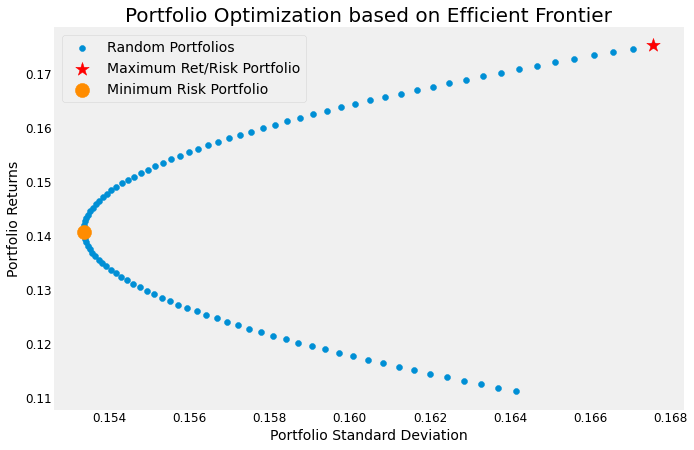

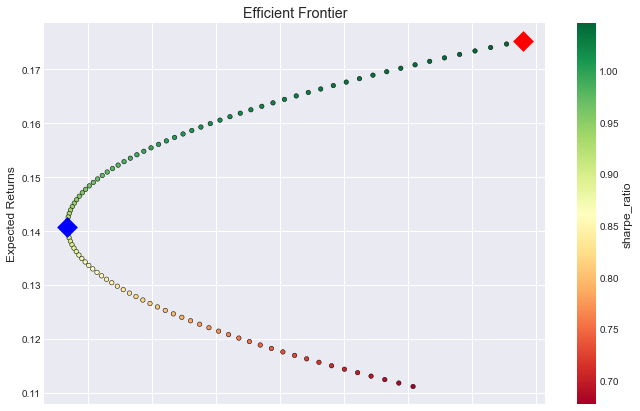

,weight_XLF,weight_XLK,returns,std_dev,sharpe_ratio
0,0.00,1.00,0.175293,0.167581,1.046020
1,0.01,0.99,0.174652,0.167076,1.045344
2,0.02,0.98,0.174011,0.166579,1.044614
3,0.03,0.97,0.173370,0.166091,1.043828
4,0.04,0.96,0.172729,0.165610,1.042986
...,...,...,...,...,...
96,0.96,0.04,0.113773,0.162425,0.700467
97,0.97,0.03,0.113132,0.162845,0.694725
98,0.98,0.02,0.112491,0.163273,0.688976
99,0.99,0.01,0.111851,0.163711,0.683221


In [23]:
# Trial function for showing efficient frontier
portfolio = create_efficient_frontier(spdrs_daily_ret_df, 'XLF', 'XLK', corr_coef = 'default')
portfolio

#### 3.2. Leftmost point of the EF is called the Global Minimum Variance Portfolio

#### 3.3. Correlation between securities = -1

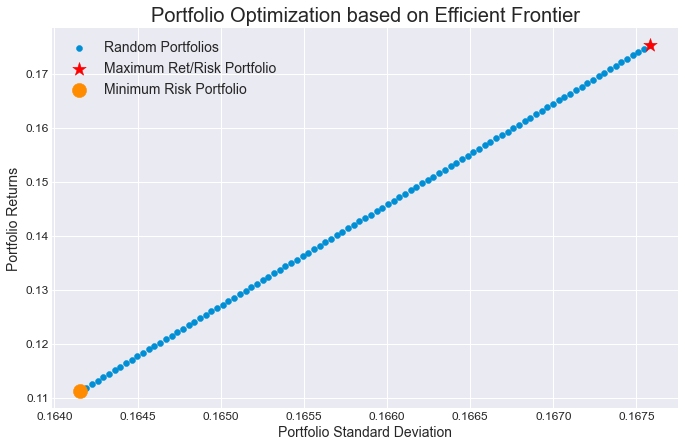

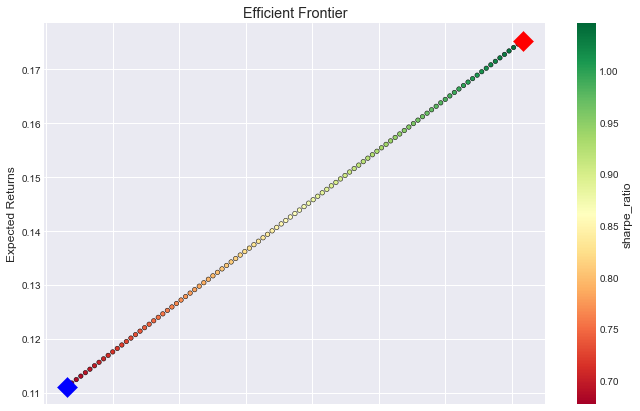

,weight_XLF,weight_XLK,returns,std_dev,sharpe_ratio
0,0.00,1.00,0.175293,0.167581,1.046020
1,0.01,0.99,0.174652,0.167546,1.042409
2,0.02,0.98,0.174011,0.167512,1.038797
3,0.03,0.97,0.173370,0.167478,1.035183
4,0.04,0.96,0.172729,0.167444,1.031567
...,...,...,...,...,...
96,0.96,0.04,0.113773,0.164293,0.692499
97,0.97,0.03,0.113132,0.164259,0.688742
98,0.98,0.02,0.112491,0.164225,0.684984
99,0.99,0.01,0.111851,0.164191,0.681223


In [24]:
# showing efficient frontier when correlation = 1
portfolio_1 = create_efficient_frontier(spdrs_daily_ret_df, 'XLF', 'XLK', corr_coef = 1)
portfolio_1

#### 3.4. Correlation between 2 securities = 0

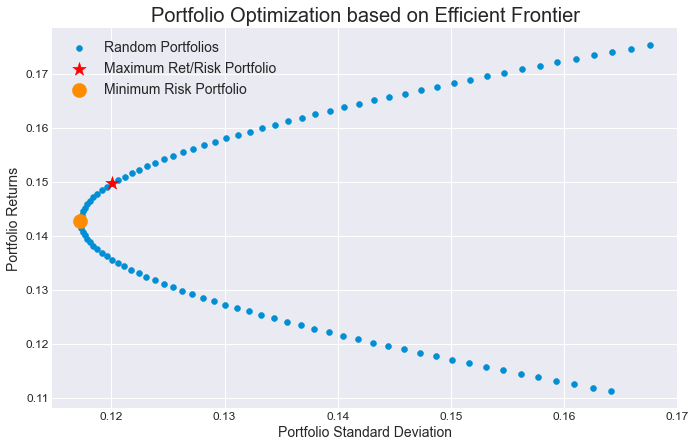

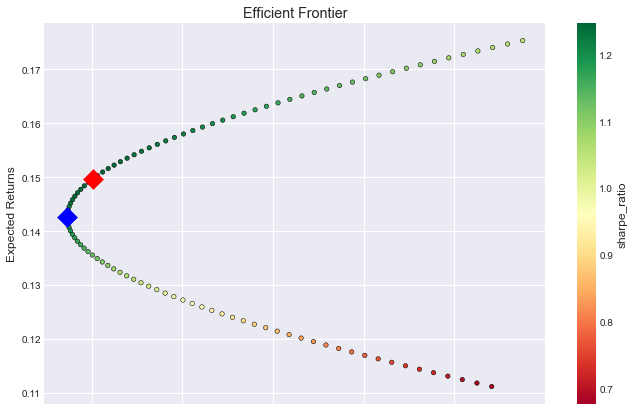

,weight_XLF,weight_XLK,returns,std_dev,sharpe_ratio
0,0.00,1.00,0.175293,0.167581,1.046020
1,0.01,0.99,0.174652,0.165913,1.052672
2,0.02,0.98,0.174011,0.164262,1.059352
3,0.03,0.97,0.173370,0.162628,1.066055
4,0.04,0.96,0.172729,0.161011,1.072778
...,...,...,...,...,...
96,0.96,0.04,0.113773,0.157733,0.721303
97,0.97,0.03,0.113132,0.159311,0.710134
98,0.98,0.02,0.112491,0.160908,0.699103
99,0.99,0.01,0.111851,0.162524,0.688211


In [25]:
# showing efficient frontier when correlation = 0
portfolio_2 = create_efficient_frontier(spdrs_daily_ret_df, 'XLF', 'XLK', corr_coef = 0)
portfolio_2

#### 3.5. Correlation between the two securities = -1

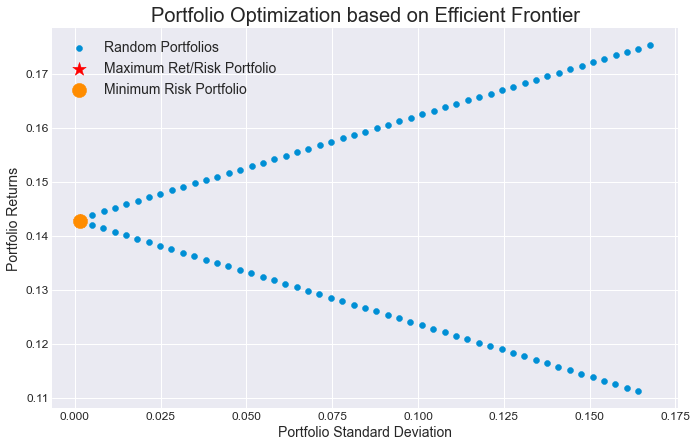

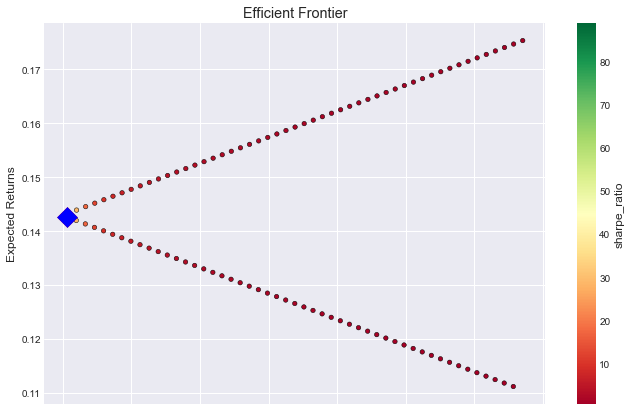

,weight_XLF,weight_XLK,returns,std_dev,sharpe_ratio
0,0.00,1.00,0.175293,0.167581,1.046020
1,0.01,0.99,0.174652,0.164263,1.063244
2,0.02,0.98,0.174011,0.160946,1.081177
3,0.03,0.97,0.173370,0.157628,1.099866
4,0.04,0.96,0.172729,0.154311,1.119358
...,...,...,...,...,...
96,0.96,0.04,0.113773,0.150887,0.754028
97,0.97,0.03,0.113132,0.154204,0.733651
98,0.98,0.02,0.112491,0.157522,0.714132
99,0.99,0.01,0.111851,0.160839,0.695419


In [26]:
# showing efficient frontier when correlation = -1
portfolio_3 = create_efficient_frontier(spdrs_daily_ret_df, 'XLF', 'XLK', corr_coef = -1)
portfolio_3

#### 3.6. Trimming the data by 5%

In [27]:
# Function for trimming
def trim_data(data_set, percent_trim):
    # Find number of rows of original data
    N = selected_etf_daily_ret_df.shape[0]
    # number required for trimming (unit in percent)
    trim = percent_trim
    # return trimmed data
    return data_set.iloc[round(trim/2*N/100) : -round(trim/2*N/100)]    # trim head 5% and trim tail 5%

In [28]:
# Trial function for trimming data
selected_etf_daily_ret_trim_5 = trim_data(selected_etf_daily_ret_df, 5)
selected_etf_daily_ret_trim_5

# new data has 1434 rows, original data has 1510 rows

,XLF,XLK
Date,,
2014-02-28,0.005095,0.001101
2014-03-03,-0.007834,-0.010729
2014-03-04,0.020437,0.013070
2014-03-05,0.010469,0.001372
2014-03-06,0.003153,0.001371
...,...,...
2019-10-30,-0.000693,0.006129
2019-10-31,-0.004854,-0.000597
2019-11-01,0.014634,0.011952


In [29]:
# Recompute the correlation from trimmed data

r1 = pearsonr(selected_etf_daily_ret_trim_5['XLF'], selected_etf_daily_ret_trim_5['XLK'])
corr_coef = r1[0]

print(f'Correlation between XLF and XLK is {corr_coef}')

Correlation between XLF and XLK is 0.7110761749212826


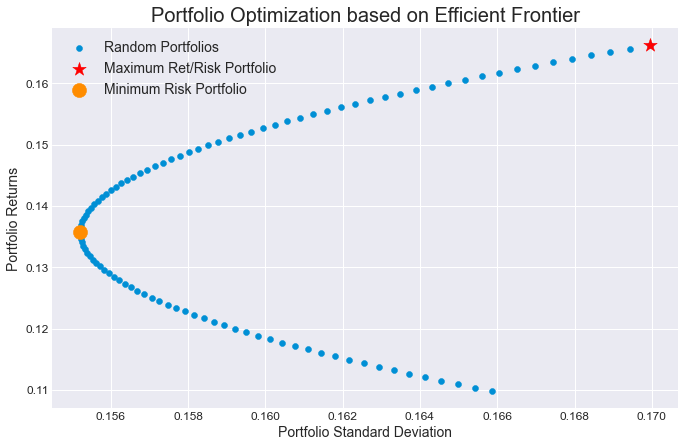

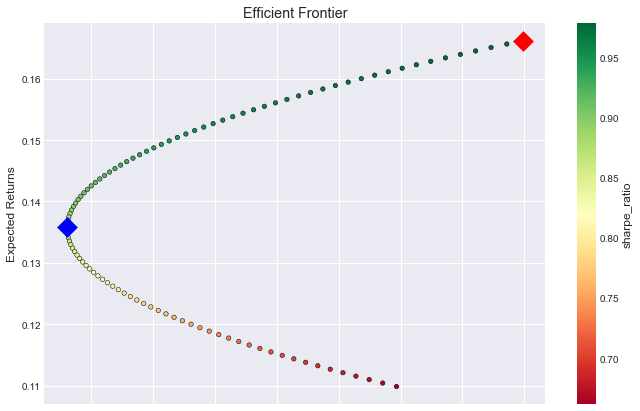

,weight_XLF,weight_XLK,returns,std_dev,sharpe_ratio
0,0.00,1.00,0.166230,0.169950,0.978111
1,0.01,0.99,0.165666,0.169434,0.977762
2,0.02,0.98,0.165102,0.168926,0.977364
3,0.03,0.97,0.164538,0.168426,0.976917
4,0.04,0.96,0.163975,0.167935,0.976419
...,...,...,...,...,...
96,0.96,0.04,0.112097,0.164136,0.682953
97,0.97,0.03,0.111533,0.164556,0.677785
98,0.98,0.02,0.110970,0.164984,0.672607
99,0.99,0.01,0.110406,0.165421,0.667420


In [30]:
# showing efficient frontier of trimmed data
portfolio_4 = create_efficient_frontier(selected_etf_daily_ret_trim_5, 'XLF', 'XLK', corr_coef = 'default')
portfolio_4

#### 3.7. Efficient Frontier with the trimmed data has slightly higher standard deviation and slightly lower sharpe ratio compared to the Efficient Frontier constructed with the original data.

#### 3.8. PyPortfolioOpt - robust method

OrderedDict([('XLF', 0.0), ('XLK', 1.0)])
Expected annual return: 19.2%
Annual volatility: 16.8%
Sharpe Ratio: 1.02


(0.19152219529229342, 0.16758051415971426, 1.0235211185044015)

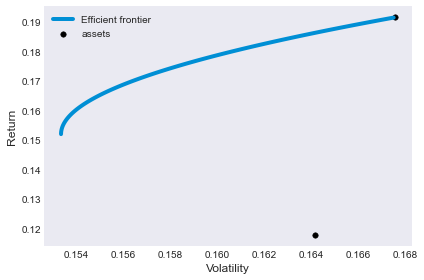

In [31]:
# Portfolio Optimization

# DataFrame of selected ETF for portfolio
df = spdrs_price_df[['XLF', 'XLK']]
# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))    # generate optimal portfolios
ef.add_constraint(lambda w: w[0]+w[1] == 1)           # adds a constraint to the optimization problem
plotting.plot_efficient_frontier(ef)
weights = ef.max_sharpe()                             # optimizes for maximal Sharpe ratio
cleaned_weights = ef.clean_weights()                  # rounds the weights and clips near-zeros
print(cleaned_weights)

ef.portfolio_performance(verbose=True)

#### 3.9. With comparison to the previous EFs, this one has higher sharpe ratio whereas the risk is pretty much the same with the EF – original data and risk is slightly lower vs the EF – trimmed data.

### 4. 3-Sector Portfolios

#### 4.1. Correlation Matrix for 3 ETF portfolio

In [32]:
# select 3 ETF (XLF, XLK, XLV)
selected_3_etf_daily_ret_df = spdrs_daily_ret_df[['XLF', 'XLK', 'XLV']]
selected_3_etf_daily_ret_df

,XLF,XLK,XLV
Date,,,
2014-01-03,0.006900,-0.004804,0.002358
2014-01-06,0.000914,-0.001704,-0.004162
2014-01-07,0.000456,0.009102,0.010540
2014-01-08,0.003194,0.000000,0.008812
2014-01-09,0.003638,-0.006482,0.007487
...,...,...,...
2019-12-24,0.002287,0.000329,-0.001261
2019-12-26,0.005541,0.007453,-0.000680
2019-12-27,-0.002593,-0.000109,0.000292


In [33]:
# compute the correlation of 3 ETFs
selected_3_etf_daily_ret_df.corr()

,XLF,XLK,XLV
XLF,1.000000,0.711007,0.672809
XLK,0.711007,1.000000,0.718604
XLV,0.672809,0.718604,1.000000


#### 4.2. Efficient Frontier of the 3-security portfolio

OrderedDict([('XLF', 0.0), ('XLK', 1.0), ('XLV', 0.0)])
Expected annual return: 19.2%
Annual volatility: 16.8%
Sharpe Ratio: 1.02


(0.19152219544779095, 0.16758051430634294, 1.023521118536744)

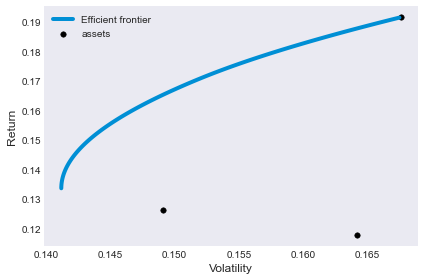

In [34]:
# Portfolio Optimization

# DataFrame of selected ETF for portfolio
df1 = spdrs_price_df[['XLF', 'XLK', 'XLV']]
# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu1 = expected_returns.mean_historical_return(df1)
S1 = risk_models.sample_cov(df1)

# Optimize for maximum sharpe ratio
ef1 = EfficientFrontier(mu1, S1, weight_bounds=(0,1))    # generate optimal portfolios
ef1.add_constraint(lambda w1: w1[0]+w1[1]+w1[2] == 1)           # adds a constraint to the optimization problem
plotting.plot_efficient_frontier(ef1)
weights1 = ef1.max_sharpe()                             # optimizes for maximal Sharpe ratio
cleaned_weights1 = ef1.clean_weights()                  # rounds the weights and clips near-zeros
print(cleaned_weights1)

ef1.portfolio_performance(verbose=True)

### 5.Portfolios with all combinations

#### 5.1. Using 2019 data. Robust method for calculation of EFs for all 165 combinations

In [35]:
# select only price data of 2019
spdrs_daily_ret_2019 = spdrs_daily_ret_df.loc['2019']
spdrs_daily_ret_2019

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2019-01-02,0.005146,0.013096,0.019704,0.008396,0.005123,0.000645,-0.005908,-0.021617,-0.017196,-0.015143,0.007575
2019-01-03,-0.028358,-0.013460,-0.009918,-0.022481,-0.030429,-0.050468,-0.005745,0.006410,-0.000192,-0.020305,-0.021652
2019-01-04,0.039319,0.041470,0.034024,0.033220,0.037916,0.044320,0.021319,0.010706,0.014808,0.029831,0.033094
2019-01-07,0.003510,0.009338,0.014865,0.001237,0.008135,0.008943,-0.001366,0.010056,-0.006822,0.003839,0.022612
2019-01-08,0.010494,0.016962,0.007735,0.000823,0.013703,0.008380,0.009181,0.018187,0.012402,0.007765,0.011056
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.001147,-0.000955,-0.000484,0.002287,-0.004019,0.000329,0.001273,0.002733,0.001406,-0.001261,0.002253
2019-12-26,0.004418,0.007754,-0.000323,0.005541,0.002323,0.007453,0.000954,0.005342,0.001717,-0.000680,0.012205
2019-12-27,-0.003747,-0.001897,-0.004198,-0.002593,-0.000854,-0.000109,0.004446,0.002711,0.002960,0.000292,-0.000079


In [36]:
# Column's name of Empty dictinary
columns = ['Portfolio', 'weight_assset_1', 'weight_assset_2', 'weight_assset_3', 'return', 'std_dev', 'sharpe_ratio']
# Empty dictionary for keep portfolio information (weight, return, stdev, sharpe)
trained_portfolios = pd.DataFrame(columns=columns)

# Find each portfolio from 165 portfolios (11 chose 3)
for port in itertools.combinations(spdrs_daily_ret_2019.columns, 3):
    port_info = []
    # select only 3 asssets that is in each portfolio
    df1 = spdrs_price_df[list(port)]
    # Return for each assets
    mu1 = expected_returns.mean_historical_return(df1)
    # Covariance matrix
    S1 = risk_models.sample_cov(df1)
    ef1 = EfficientFrontier(mu1, S1, weight_bounds=(None,None))    # generate optimal portfolios
    ef1.add_constraint(lambda w1: w1[0]+w1[1]+w1[2] == 1)          # adds a constraint to the optimization problem
    weights1 = ef1.max_sharpe()                                    # optimizes for maximal Sharpe ratio
    cleaned_weights1 = ef1.clean_weights()                         # rounds the weights and clips near-zeros
    # get portfolio performance (return, standard deviation, sharpe ration)
    port_perf = ef1.portfolio_performance(verbose=False)
    # keep all value (elements portfolio, 3 weights, 3 portfolio performances) in empty list
    port_info.extend([port, 
                      cleaned_weights1[port[0]],cleaned_weights1[port[1]],cleaned_weights1[port[2]],
                      port_perf[0], port_perf[1], port_perf[2]])
    
    # transform list to row of dataframe
    df_length = len(trained_portfolios)
    trained_portfolios.loc[df_length] = port_info
    
# setting for show all rows of DataFrame
pd.set_option('display.max_rows', None)

trained_portfolios

,Portfolio,weight_assset_1,weight_assset_2,weight_assset_3,return,std_dev,sharpe_ratio
0,"(XLB, VOX, XLE)",1.00000,1.00000,-1.00000,0.143708,0.205211,0.602836
1,"(XLB, VOX, XLF)",0.16545,-0.16545,1.00000,0.122037,0.170058,0.600012
2,"(XLB, VOX, XLI)",0.11062,-0.11062,1.00000,0.104486,0.154673,0.546226
3,"(XLB, VOX, XLK)",0.15657,-0.15657,1.00000,0.195719,0.170243,1.032166
4,"(XLB, VOX, XLP)",0.20925,-0.20925,1.00000,0.102508,0.120437,0.685067
5,"(XLB, VOX, IYR)",0.30027,-0.30027,1.00000,0.116231,0.139837,0.688167
6,"(XLB, VOX, XLU)",0.29267,-0.28724,0.99457,0.140704,0.142808,0.845215
7,"(XLB, VOX, XLV)",0.17964,-0.17964,1.00000,0.131055,0.153738,0.722364
8,"(XLB, VOX, XLY)",0.20262,-0.20262,1.00000,0.132938,0.150955,0.748157
9,"(XLB, XLE, XLF)",1.00000,-1.00000,1.00000,0.216890,0.217434,0.905514


#### 5.2. Fixed risk of 16%. New EFs

In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
spdrs_list= "XLP XLE XLF XLV XLI XLC XLY XLB XLK XLU XLRE"
spdrs_price= yf.download(spdrs_list)['Adj Close']
spdrs_price_data=spdrs_price.pct_change()
import itertools as it

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov, CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import pypfopt as pf
from pypfopt import plotting

etf_combinations=[comb for comb in it.combinations(spdrs_price_data.columns,3)] #all combinations 3 of 11


portfolio_weights_target = pd.DataFrame(index = etf_combinations)
prices19 = spdrs_price['2019'] 
target_vol = 0.16 # fixed amount of risk - target volatlity

for comb in etf_combinations:
    p3=prices19[list(comb)].dropna() #prices of 3 ETFs
    risk=CovarianceShrinkage(p3).ledoit_wolf()
    ef=EfficientFrontier(mean_historical_return(p3,compounding=False), risk,weight_bounds=(-1,1))
    
    weights = ef.efficient_risk(target_vol)
    for key in weights:
        portfolio_weights_target.loc[[comb],key] = weights[key]

portfolio_weights_target = portfolio_weights_target.fillna(0)
portfolio_weights_target.head(10)

[*********************100%***********************]  11 of 11 completed


,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
"(XLB, XLC, XLE)",0.600171,0.781237,-0.381408,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
"(XLB, XLC, XLF)",-0.372292,0.441681,0.000000,0.930611,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
"(XLB, XLC, XLI)",-0.426526,0.577203,0.000000,0.000000,0.849323,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
"(XLB, XLC, XLK)",0.171016,0.162793,0.000000,0.000000,0.000000,0.666191,0.000000,0.0,0.000000,0.000000,0.000000
"(XLB, XLC, XLP)",-0.747558,0.763582,0.000000,0.000000,0.000000,0.000000,0.983976,0.0,0.000000,0.000000,0.000000
"(XLB, XLC, XLRE)",-0.540003,0.540003,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
"(XLB, XLC, XLU)",-0.613784,0.902376,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.711407,0.000000,0.000000
"(XLB, XLC, XLV)",0.162686,0.944816,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.107501,0.000000
"(XLB, XLC, XLY)",-0.293999,0.681111,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.612888
"(XLB, XLE, XLF)",0.339499,0.000000,-0.315515,0.976016,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


#### 5.3. 2019 Portfolio Return rankings

In [38]:
portfolio_returns_2019 = portfolio_weights_target.dot(spdrs_price_data['2019'].mean()*252) #annualized returns for 2019
display(pd.DataFrame(portfolio_returns_2019.sort_values(ascending=False), columns = ['portfolio_returns_2019']))

,portfolio_returns_2019
"(XLE, XLK, XLU)",0.455575
"(XLK, XLU, XLV)",0.454603
"(XLE, XLK, XLRE)",0.447021
"(XLK, XLRE, XLV)",0.441472
"(XLE, XLK, XLP)",0.440273
"(XLB, XLK, XLU)",0.426605
"(XLB, XLK, XLRE)",0.425758
"(XLK, XLP, XLV)",0.425240
"(XLK, XLRE, XLY)",0.421434
"(XLB, XLK, XLP)",0.419203


#### 5.4. 2020 data using 165 portfolios

In [39]:
test_portfolio = portfolio_weights_target.dot(spdrs_price_data['2020'].mean()*252).to_frame('Ret2020')

#Daily return variances
test_portfolio['DailyVar2020'] = portfolio_weights_target.apply(lambda weights: weights.dot(spdrs_price_data['2020'].cov()).dot(weights.T), axis=1)
test_portfolio['Vol2020'] = np.sqrt(test_portfolio.DailyVar2020*252) #annualized st.dev (volatility)
test_portfolio['Sharpe2020'] = (test_portfolio.Ret2020-0.01)/test_portfolio.Vol2020 # Sharpe ratio with risk-free rate = 1%

test_portfolio['Ret2019'] = portfolio_returns_2019
test_portfolio['Difference']=test_portfolio.Ret2020-test_portfolio.Ret2019
test_portfolio['SquaredDiff'] = test_portfolio.Difference**2
display(test_portfolio)
print('Mean Squared Difference:', test_portfolio.SquaredDiff.mean())

,Ret2020,DailyVar2020,Vol2020,Sharpe2020,Ret2019,Difference,SquaredDiff
"(XLB, XLC, XLE)",0.464184,0.000417,0.323983,1.401878,0.309774,0.154410,2.384258e-02
"(XLB, XLC, XLF)",0.112235,0.000683,0.414972,0.246365,0.309131,-0.196896,3.876802e-02
"(XLB, XLC, XLI)",0.212665,0.000492,0.352013,0.575732,0.293667,-0.081002,6.561374e-03
"(XLB, XLC, XLK)",0.386266,0.000554,0.373785,1.006638,0.365834,0.020431,4.174434e-04
"(XLB, XLC, XLP)",0.162231,0.000360,0.301169,0.505468,0.290332,-0.128101,1.640975e-02
"(XLB, XLC, XLRE)",0.076968,0.000568,0.378346,0.177001,0.290210,-0.213243,4.547240e-02
"(XLB, XLC, XLU)",0.161213,0.000476,0.346478,0.436429,0.284715,-0.123501,1.525260e-02
"(XLB, XLC, XLV)",0.300485,0.000452,0.337459,0.860801,0.284503,0.015982,2.554262e-04
"(XLB, XLC, XLY)",0.316964,0.000436,0.331301,0.926543,0.285512,0.031452,9.892113e-04
"(XLB, XLE, XLF)",0.237338,0.000668,0.410378,0.553971,0.318749,-0.081411,6.627761e-03


Mean Squared Difference: 0.029733889752703982


#### 5.5. Ranking of the 2020 returns

In [40]:
#first, rank by 2020 return
test_portfolio.Ret2020.sort_values(ascending=False)

(XLE, XLK, XLU)     0.545141
(XLE, XLV, XLY)     0.535192
(XLB, XLE, XLY)     0.534314
(XLE, XLK, XLP)     0.533913
(XLE, XLU, XLY)     0.513726
(XLE, XLP, XLY)     0.501592
(XLC, XLE, XLY)     0.495361
(XLE, XLK, XLRE)    0.485395
(XLE, XLI, XLY)     0.467898
(XLB, XLC, XLE)     0.464184
(XLE, XLK, XLY)     0.450609
(XLE, XLK, XLV)     0.445278
(XLC, XLE, XLP)     0.444324
(XLB, XLE, XLV)     0.442663
(XLF, XLK, XLU)     0.439880
(XLF, XLK, XLP)     0.434762
(XLB, XLE, XLP)     0.429277
(XLE, XLI, XLP)     0.423920
(XLE, XLRE, XLY)    0.421125
(XLI, XLK, XLU)     0.417831
(XLC, XLE, XLV)     0.416254
(XLI, XLK, XLP)     0.415973
(XLF, XLK, XLRE)    0.413878
(XLC, XLE, XLU)     0.412676
(XLE, XLI, XLU)     0.402430
(XLC, XLE, XLI)     0.401299
(XLE, XLI, XLV)     0.400422
(XLC, XLK, XLU)     0.396360
(XLB, XLK, XLY)     0.396355
(XLC, XLK, XLY)     0.395817
(XLB, XLE, XLK)     0.394971
(XLK, XLP, XLU)     0.393556
(XLK, XLRE, XLU)    0.389514
(XLB, XLE, XLU)     0.387211
(XLB, XLC, XLK

In [41]:
#second, rank by 2020 Sharpe ratio
test_portfolio.Sharpe2020.sort_values(ascending=False)

(XLB, XLE, XLY)     1.578768
(XLE, XLV, XLY)     1.564736
(XLC, XLE, XLY)     1.479173
(XLE, XLP, XLY)     1.424138
(XLE, XLK, XLP)     1.417869
(XLB, XLC, XLE)     1.401878
(XLE, XLI, XLY)     1.365336
(XLB, XLE, XLV)     1.325532
(XLE, XLK, XLU)     1.287795
(XLE, XLU, XLY)     1.280124
(XLC, XLE, XLV)     1.275033
(XLB, XLE, XLP)     1.248132
(XLC, XLE, XLP)     1.231897
(XLE, XLK, XLY)     1.223954
(XLE, XLK, XLV)     1.219006
(XLC, XLE, XLI)     1.197637
(XLE, XLI, XLP)     1.188486
(XLE, XLK, XLRE)    1.176752
(XLF, XLK, XLP)     1.171973
(XLE, XLI, XLV)     1.164627
(XLF, XLK, XLU)     1.103827
(XLE, XLRE, XLY)    1.085778
(XLI, XLK, XLP)     1.083101
(XLC, XLE, XLU)     1.052701
(XLC, XLK, XLY)     1.040230
(XLB, XLK, XLY)     1.032357
(XLB, XLE, XLK)     1.027308
(XLF, XLK, XLRE)    1.026618
(XLI, XLK, XLU)     1.026048
(XLE, XLF, XLY)     1.023463
(XLB, XLC, XLK)     1.006638
(XLE, XLP, XLV)     1.004326
(XLK, XLP, XLV)     0.998268
(XLI, XLK, XLY)     0.993393
(XLK, XLV, XLY

In [42]:
#finally, rank by the least squared difference 2020-2019 (out-of-sample consistence)
test_portfolio.SquaredDiff.rank().sort_values()

(XLB, XLI, XLK)       1.0
(XLC, XLI, XLP)       2.0
(XLC, XLE, XLRE)      3.0
(XLI, XLK, XLU)       4.0
(XLE, XLU, XLV)       5.0
(XLC, XLI, XLK)       6.0
(XLI, XLK, XLP)       7.0
(XLC, XLE, XLK)       8.0
(XLC, XLI, XLU)       9.0
(XLE, XLI, XLRE)     10.0
(XLB, XLK, XLV)      11.0
(XLI, XLV, XLY)      12.0
(XLI, XLK, XLV)      13.0
(XLK, XLV, XLY)      14.0
(XLC, XLK, XLV)      15.0
(XLB, XLE, XLRE)     16.0
(XLF, XLK, XLRE)     17.0
(XLK, XLRE, XLU)     18.0
(XLK, XLP, XLU)      19.0
(XLB, XLE, XLI)      20.0
(XLE, XLI, XLK)      21.0
(XLC, XLK, XLU)      22.0
(XLI, XLK, XLY)      23.0
(XLB, XLC, XLV)      24.0
(XLB, XLC, XLK)      25.0
(XLE, XLP, XLU)      26.0
(XLC, XLP, XLU)      27.0
(XLF, XLK, XLV)      28.0
(XLE, XLF, XLV)      29.0
(XLC, XLK, XLY)      30.0
(XLB, XLK, XLY)      31.0
(XLB, XLC, XLY)      32.0
(XLF, XLK, XLU)      33.0
(XLC, XLK, XLP)      34.0
(XLC, XLE, XLF)      35.0
(XLE, XLF, XLY)      36.0
(XLF, XLK, XLP)      37.0
(XLB, XLE, XLK)      38.0
(XLE, XLK, X

### 6. 3-Security Portfolio

#### 6.1. Using Economic Indicators (LEI,LAG,CEI)

In [43]:
# Import GWP1 metrics
lei = pd.read_csv('lei.csv',index_col=0)
lei

,RSquared,MSE,AIC
ETFS,,,
XLB,0.262826,0.003827,-244.270779
XLC,0.297244,0.001197,-340.281439
XLE,0.203488,0.004708,-205.361578
XLF,0.489401,0.007102,-270.968658
XLI,0.419054,0.005357,-270.798157
XLK,0.503811,0.007009,-276.066824
XLP,0.254986,0.001930,-290.617246
XLRE,0.175131,0.001227,-288.858964
XLU,0.153733,0.001462,-265.034657


In [44]:
# Import GWP1 metrics
lag = pd.read_csv('lag.csv',index_col=0)
lag

,RSquared,MSE,AIC
ETFS,,,
XLB,0.058405,0.001215,-232.648697
XLC,0.053409,0.000307,-324.835721
XLE,0.043053,0.001423,-198.149153
XLF,0.146384,0.003035,-239.968051
XLI,0.078100,0.001426,-243.550082
XLK,0.177864,0.003535,-245.710448
XLP,0.080660,0.000872,-281.479019
XLRE,0.109224,0.001093,-289.324438
XLU,0.152627,0.002073,-270.940573


In [45]:
# Import GWP1 metrics
cei = pd.read_csv('cei.csv',index_col=0)
cei

,RSquared,MSE,AIC
ETFS,,,
XLB,0.034218,0.001661,-238.822545
XLC,0.038250,0.000513,-331.691833
XLE,0.017972,0.001386,-204.286354
XLF,0.066126,0.003198,-241.498134
XLI,0.058395,0.002488,-250.027345
XLK,0.142021,0.006586,-250.638006
XLP,0.081977,0.002069,-289.582249
XLRE,0.063903,0.001492,-293.751390
XLU,0.089929,0.002850,-273.801087


In [46]:
#combine MSE for all 3 indicators
mse_all = lei.MSE.to_frame('LEI_mse')
mse_all['CEI_mse'] = cei.MSE
mse_all['LAG_mse'] = lag.MSE
mse_all

,LEI_mse,CEI_mse,LAG_mse
ETFS,,,
XLB,0.003827,0.001661,0.001215
XLC,0.001197,0.000513,0.000307
XLE,0.004708,0.001386,0.001423
XLF,0.007102,0.003198,0.003035
XLI,0.005357,0.002488,0.001426
XLK,0.007009,0.006586,0.003535
XLP,0.001930,0.002069,0.000872
XLRE,0.001227,0.001492,0.001093
XLU,0.001462,0.002850,0.002073


In [47]:
#find best fit for each ETF
mse_all['best_fit']=mse_all.apply(lambda x: x.idxmax(), axis=1)
mse_all

,LEI_mse,CEI_mse,LAG_mse,best_fit
ETFS,,,,
XLB,0.003827,0.001661,0.001215,LEI_mse
XLC,0.001197,0.000513,0.000307,LEI_mse
XLE,0.004708,0.001386,0.001423,LEI_mse
XLF,0.007102,0.003198,0.003035,LEI_mse
XLI,0.005357,0.002488,0.001426,LEI_mse
XLK,0.007009,0.006586,0.003535,LEI_mse
XLP,0.001930,0.002069,0.000872,CEI_mse
XLRE,0.001227,0.001492,0.001093,CEI_mse
XLU,0.001462,0.002850,0.002073,CEI_mse


In [48]:
def NewLabel(etf, weight):
    if weight >0:
        return '+'+mse_all.best_fit[etf]
    elif weight <0:
        return '-'+mse_all.best_fit[etf]
    else:
        return ''

target_relabeled= pd.DataFrame(index=etf_combinations, columns=portfolio_weights_target.columns)

tw= portfolio_weights_target.apply(lambda etfs: [NewLabel(etf, weight) for etf, weight in dict(etfs).items()], axis=1)

for comb in etf_combinations:
    target_relabeled.loc[[comb],:] = tw[comb]

target_relabeled.head(20)

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
"(XLB, XLC, XLE)",+LEI_mse,+LEI_mse,-LEI_mse,,,,,,,,
"(XLB, XLC, XLF)",-LEI_mse,+LEI_mse,,+LEI_mse,,,,,,,
"(XLB, XLC, XLI)",-LEI_mse,+LEI_mse,,,+LEI_mse,,,,,,
"(XLB, XLC, XLK)",+LEI_mse,+LEI_mse,,,,+LEI_mse,,,,,
"(XLB, XLC, XLP)",-LEI_mse,+LEI_mse,,,,,+CEI_mse,,,,
"(XLB, XLC, XLRE)",-LEI_mse,+LEI_mse,,,,,,+CEI_mse,,,
"(XLB, XLC, XLU)",-LEI_mse,+LEI_mse,,,,,,,+CEI_mse,,
"(XLB, XLC, XLV)",+LEI_mse,+LEI_mse,,,,,,,,-LEI_mse,
"(XLB, XLC, XLY)",-LEI_mse,+LEI_mse,,,,,,,,,+LEI_mse
"(XLB, XLE, XLF)",+LEI_mse,,-LEI_mse,+LEI_mse,,,,,,,


In [49]:
#selecting the best 20 combinations according to the best Sharpe ratio in 2020 
best20 = test_portfolio.Sharpe2020.sort_values(ascending=False).head(20)
best20

(XLB, XLE, XLY)     1.578768
(XLE, XLV, XLY)     1.564736
(XLC, XLE, XLY)     1.479173
(XLE, XLP, XLY)     1.424138
(XLE, XLK, XLP)     1.417869
(XLB, XLC, XLE)     1.401878
(XLE, XLI, XLY)     1.365336
(XLB, XLE, XLV)     1.325532
(XLE, XLK, XLU)     1.287795
(XLE, XLU, XLY)     1.280124
(XLC, XLE, XLV)     1.275033
(XLB, XLE, XLP)     1.248132
(XLC, XLE, XLP)     1.231897
(XLE, XLK, XLY)     1.223954
(XLE, XLK, XLV)     1.219006
(XLC, XLE, XLI)     1.197637
(XLE, XLI, XLP)     1.188486
(XLE, XLK, XLRE)    1.176752
(XLF, XLK, XLP)     1.171973
(XLE, XLI, XLV)     1.164627
Name: Sharpe2020, dtype: float64

In [50]:
#Relabelled data for the best 20 combinations
target_relabeled.loc[best20.index]

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
"(XLB, XLE, XLY)",+LEI_mse,,-LEI_mse,,,,,,,,+LEI_mse
"(XLE, XLV, XLY)",,,-LEI_mse,,,,,,,+LEI_mse,+LEI_mse
"(XLC, XLE, XLY)",,+LEI_mse,-LEI_mse,,,,,,,,+LEI_mse
"(XLE, XLP, XLY)",,,-LEI_mse,,,,+CEI_mse,,,,+LEI_mse
"(XLE, XLK, XLP)",,,-LEI_mse,,,+LEI_mse,+CEI_mse,,,,
"(XLB, XLC, XLE)",+LEI_mse,+LEI_mse,-LEI_mse,,,,,,,,
"(XLE, XLI, XLY)",,,-LEI_mse,,+LEI_mse,,,,,,+LEI_mse
"(XLB, XLE, XLV)",+LEI_mse,,-LEI_mse,,,,,,,+LEI_mse,
"(XLE, XLK, XLU)",,,-LEI_mse,,,+LEI_mse,,,+CEI_mse,,
"(XLE, XLU, XLY)",,,-LEI_mse,,,,,,+CEI_mse,,+LEI_mse


### 7. Portfolios with 4 assets using Principal Components

#### 7.1. PCA for the correlatio matrix of 11 ETFs

In [51]:
rets2019=spdrs_price_data['2019']
#eigen-decompose correlation matirix
eig_val, eig_vec = np.linalg.eig(rets2019.corr()) 
# index of sorted eigenvalues
sort_idx = np.argsort(eig_val)[::-1] 
#first 3 components
n_comp = eig_vec[sort_idx[:3]] 
#projected returns on 3 components
rets2019_proj = rets2019.dot(n_comp.T) 
rets2019_proj

,0,1,2
Date,,,
2019-01-02,-0.002569,0.005178,-3.156821e-04
2019-01-03,-0.003454,-0.028294,-1.246115e-02
2019-01-04,0.005594,0.051364,8.919224e-03
2019-01-07,-0.007677,0.005191,4.396667e-03
2019-01-08,-0.001440,0.015903,5.660614e-03
2019-01-09,-0.007838,0.010497,-1.606296e-03
2019-01-10,-0.004106,0.014170,-1.628612e-03
2019-01-11,0.000066,-0.008585,-3.077312e-03
2019-01-14,-0.009713,-0.018505,-1.085344e-02


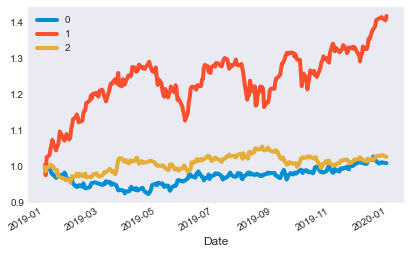

In [53]:
#cummulative return for 3 components
(1+rets2019_proj).cumprod().plot();

#### 7.2. Using 2019 data, EF for the first three principal components

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

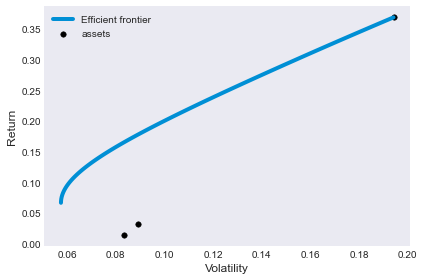

In [54]:
ef_pca = EfficientFrontier(rets2019_proj.mean()*252,sample_cov(rets2019_proj,returns_data=True))
plotting.plot_efficient_frontier(ef_pca)

#### 7.3. Comparison of PCA Portfolio Return vs 2019 3-Security Portfolio Returns

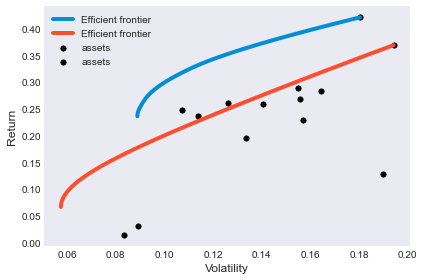

In [56]:
EF_2019 = EfficientFrontier(spdrs_price_data['2019'].mean()*252,sample_cov(spdrs_price_data['2019'],returns_data=True))

plotting.plot_efficient_frontier(EF_2019, show_assets=True);
plotting.plot_efficient_frontier(ef_pca, show_assets=True);

#### 7.4. Fixed amount of risk = 30% & 2020 data using the principal component weights

In [57]:
target_vol=0.30
pc3_weights = ef_pca.efficient_risk(target_vol)
pc3_weights

OrderedDict([(0, 7.12356e-11), (1, 0.9999999997543624), (2, 1.753685e-10)])

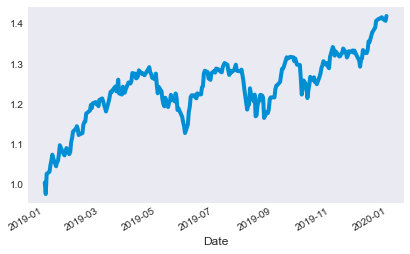

In [58]:
pc3_return = rets2019_proj.dot(np.array(list(pc3_weights.values())))
pc3_cumret = (1+pc3_return).cumprod()
pc3_cumret.plot();

#### 7.5. PCA portfolio return comparison vs the 2020 3-Security Portfolio

In [59]:
rets2020=spdrs_price_data['2020']
EF_2020 = EfficientFrontier(rets2020.mean()*252,sample_cov(rets2020,returns_data=True))
weights_2020 = EF_2020.efficient_risk(target_vol)
weights_2020

OrderedDict([('XLB', 5.498722e-10),
             ('XLC', 0.2695963737164541),
             ('XLE', 2.56461e-11),
             ('XLF', 9.43474e-11),
             ('XLI', 2.305617e-10),
             ('XLK', 0.0091276205672947),
             ('XLP', 0.3222171335999272),
             ('XLRE', 1.27383e-10),
             ('XLU', 2.110336e-10),
             ('XLV', 3.78279e-09),
             ('XLY', 0.3990588670947416)])

In [60]:
portfolio_return2020 = rets2020.dot(np.array(list(weights_2020.values())))
port2020_cumret = (1+portfolio_return2020).cumprod()

print(f'2019 mean daily return of 3 PC (at {target_vol}):',pc3_return.mean())
print(f'2020 mean daily return of 11 ETFs portfolio  (at {target_vol}):',portfolio_return2020.mean())

2019 mean daily return of 3 PC (at 0.3): 0.0014645818401381665
2020 mean daily return of 11 ETFs portfolio  (at 0.3): 0.0010019042973410542


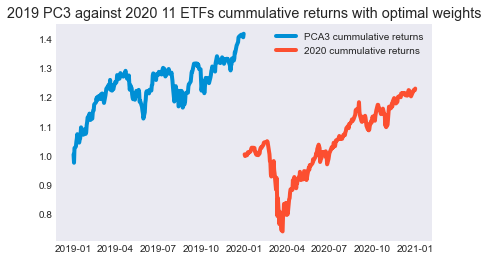

In [62]:
import matplotlib.pyplot as plt
plt.plot(pc3_cumret, label='PCA3 cummulative returns')
plt.plot(port2020_cumret, label='2020 cummulative returns')
plt.title(f'2019 PC3 against 2020 11 ETFs cummulative returns with optimal weights')
plt.legend();